# UWL phenotyping: comparison of ML algorithms

Updated 22 06 25

This notebook contains the code for training and testing models for predicting which patients have unintended weight loss, using the reasons for encounter fields.

## Structure of this notebook

1) **Load the datasets** that have been extracted from the Patron and MedicineInsight Primary Care databases
2) **Combine data sources**
3) Define functions that are useful for **processing data, evaluating models and compute bootstrap estimates**
4) Apply **data transformations**
5) Create **training and test datasets**
6) The various **ML models to train and test** and compare against each other (Naive Bayes, Decision Trees, Random Forests, Logistic Regression, ClinicalBERT, simple rule-based algorithm)

Note that we did not consider machine learning models that use multiple events in the patients' medical records, only performing text classification on the likely candidate for the index event. As a result we did not consider algorithms such as Deep Patient or Phe2Vec.

## Performance measures

We compute point estimates and 95% confidence intervals for AUC, PPV, NPV, Sensitivity and Specificity, along with ROC curves. These are computed for the entire dataset and also for male and female subgroups.

## Data sources

Two primary care databases were used in this project:
1) MedicineWise MedicineInsight to train models
2) Patron for validation.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from tqdm import tqdm

%matplotlib inline
sns.set()

# 1. Load data

In [ ]:
folder = '/Users/alexlee/Desktop/Projects/data_connect/uwl_phenotyping/data'

## 1.1. Datasets without gender variable

### 1.1.1. MedicineInsight data

In [110]:
# medicineinsight data
df_nps = (
    pd.read_csv(f'{folder}/medicine_insight/labels_gold_030323.csv')
    .assign(label=lambda df_: df_.label.astype(int))
    .rename(columns={'reason': 'text'})
    .assign(data_source='medicineinsight')
)

### 1.1.2. Patron data


In [111]:
# 1: Javi's labelling
# 2: Lucas's labelling
# 3: labellling disagreements
df_patron1 = (
    pd.read_excel(f'{folder}/patron_310523/patron_labelling_workbook_210323_060723.xlsx', sheet_name='Labels_JMG')
    .loc[:, ['text', 'label']]
)
             
df_patron2 = (
        pd.read_excel(f'{folder}/patron_310523/patron_labelling_workbook_210323_060723.xlsx', sheet_name='Labels_LDM')
        .loc[:, ['text', 'label']]
)

df_patron3 = (
    pd.read_csv(f'{folder}/patron_310523/label_disagreements_jmg_ldm_080623.csv')
    .loc[:, ['text', 'label_jmg', 'label_ldm', 'label_al']]
)

#df_patron

In [112]:
# patron tidy up
df_patron12 = pd.concat(
    [
        df_patron1.rename(columns={'label': 'label_jmg'}), 
        df_patron2.rename(columns={'label': 'label_ldm'}).loc[:, 'label_ldm']
    ], 
    axis=1
)

df_patron = pd.concat(
    [
        df_patron12.query('label_jmg == label_ldm').rename(columns={'label_jmg': 'label'}).loc[:, ['text', 'label']],
        df_patron3.rename(columns={'label_al': 'label'}).loc[:, ['text', 'label']]
    ],
    axis=0
).assign(data_source="patron")

df_patron = df_patron.assign(label=lambda df_: df_.label.astype(str).str.replace('?', '-1').astype(int)).query('label != -1')

## 1.2. Datasets with gender variable

- 1: Female
- 2: Male

In [113]:
df_nps_gender = pd.read_csv('../data/latest_export_300525/labelled_texts_nps_g.csv').assign(source='nps')

# validation data exludes those patients who are common to both nps and patron
df_val_gender = pd.read_csv('../data/latest_export_300525/labelled_texts_val_g.csv').assign(source='patron')
df_all_gender = pd.concat([df_nps_gender, df_val_gender]).reset_index().iloc[:, 1:]

## 1.3. Stats on the labelling datasets

In [114]:
# NPS: number of distinct texts
df_nps_gender.value.unique().shape[0]

2462

In [115]:
# NPS: number of each label

In [116]:
# validation: number of distinct texts
df_val_gender.value.unique().shape[0]

770

In [117]:
# total: number of distinct texts
pd.concat([df_nps_gender, df_val_gender]).value.unique().shape[0]

3101

In [118]:
# number of unseen texts in validation dataset
pd.concat([df_nps_gender, df_val_gender]).value.unique().shape[0] - df_nps_gender.value.unique().shape[0]

639

In [119]:
df_val_gender.loc[:, ['value', 'label2']].drop_duplicates().label2.value_counts()

label2
2    346
1    227
3    197
Name: count, dtype: int64

# 2. Combine datasets

## 2.1. Patron data tidy up

Create a gold standard dataset that combine the agreed and disagreed labels

In [120]:
# patron data from first two labellers
df_patron12 = pd.concat(
    [
        df_patron1.rename(columns={'label': 'label_jmg'}), 
        df_patron2.rename(columns={'label': 'label_ldm'}).loc[:, 'label_ldm']
    ], 
    axis=1
)

In [121]:
# patron data from all three labellers
df_patron = pd.concat(
    [
        df_patron12.query('label_jmg == label_ldm').rename(columns={'label_jmg': 'label'}).loc[:, ['text', 'label']],
        df_patron3.rename(columns={'label_al': 'label'}).loc[:, ['text', 'label']]
    ],
    axis=0
).assign(data_source="patron")

df_patron = df_patron.assign(label=lambda df_: df_.label.astype(str).str.replace('?', '-1').astype(int)).query('label != -1')

## 2.2. Combine MedicineInsight and Patron

In [122]:
df_all = (
    pd.concat([df_patron, df_nps])
    .assign(label=lambda df_: df_.label.map({1: 1, 2: 2, 3: 3, 4: 3}))
    .assign(label_binary=lambda df_: df_.label.map({1:1, 2: 1, 3: 0}))
)

# 3. Utility functions

## 3.1. Text processing

From: https://github.com/VCCCDataConnect/uwl/blob/main/phenotyping/4_uwl_phenotype_patron_rule_based.ipynb

In [123]:
def preprocess_text(texts):
    """
    Preprocessing of strings from encounter reasons to ensure
    relevant non-alphanumeric characters are treated as tokens
    and others are removed.
    
    Parameters
    ----------
    texts : pd.Series, list, np.array 
        input reasons for encounter texts 
    
    Returns
    -------
    texts : pd.Series 
        the processed text after applying transformations
    """
    weight_measurement_pattern2 = r'([0-9]+\s{0,1}kg)'
    weight_measurement_pattern1 = r'([0-9]+\.[0-9]+\s{0,1}kg)'
    weight_measurement_pattern = r'|'.join([weight_measurement_pattern1, weight_measurement_pattern2])
    
    number_pattern = r'([0-9]+)'
    months_pattern = r'([0-9]+)\s{0,1}\/\s{0,1}12'
    weeks_pattern = r'([0-9]+)\s{0,1}\/\s{0,1}52'
    days_pattern = r'([0-9]+)\s{0,1}\/\s{0,1}7'
    
    token_pattern = r'([\!\/\?\+\<\>])'
    remove_pattern = r'[\.\,\;\:\-]'

    texts = (
        pd.Series(texts)
        .str.lower()
        .str.replace(weeks_pattern, r'\1 weeks', regex=True)
        .str.replace(days_pattern, r'\1 days', regex=True)
        .str.replace(months_pattern, r'\1 months', regex=True)
        .str.replace(weight_measurement_pattern, '[weight_measurement]', regex=True)
        .str.replace(number_pattern, '[number_value]', regex=True)
        .str.replace(token_pattern, r' \1 ', regex=True)
        .str.replace(remove_pattern, ' ', regex=True)
        .str.replace('[ ]+', ' ', regex=True)
        .str.strip()
    )
    
    return texts

# define the tokenizer for the text
def custom_tokenizer(text):
    return re.findall(r"\b\w+\b|[!?]+", text)  # includes words and any sequence of ! or ?

## 3.2. Bootstrap functions

- Create bootstrap samples
- Estimate confidence intervals
- Do this for sensitivity, specificity, ppv, npv, auc

In [124]:
def calculate_bootstrap_samples(sample, num_bootstrap_samples):
    sample = np.array(sample)
    indices = np.arange(0, len(sample))
    bootstrap_samples = [sample[np.random.choice(indices, len(indices))] for _ in range(num_bootstrap_samples)]
    return bootstrap_samples

#def calculate_bootstrap_ci(sample, statistic='ppv', num_bootstrap_samples=1024, ci=0.95):
#    bootstrap_samples = calculate_bootstrap_samples(sample, num_bootstrap_samples)

In [125]:
def calculate_ci(estims, ci=0.95):
    estims.sort()
    L = len(estims)
    interval = (1-ci) / 2
    lower_bound = int(interval*L)
    upper_bound = int((1-interval)*L)
    return np.mean(estims).item(), estims[lower_bound], estims[upper_bound]


# calculate the performance stats using bootstrap
def calculate_bootstrap_ci(sample, 
                           num_bootstrap_samples=1024, 
                           ci=0.95, 
                           threshold=0.5):
    """
    Calculate confidence intervals for AUC, PPV, NPV, specificity and sensitivity
    based on a given dataset for a model

    Parameters
    ----------
    model (sklearn.pipeline) : the model that we are making predictions for
    sample (list of triplets of (y, y_probs) values) : the sample to calculate bootstrap samples from
    huggingface_model (bool) : whether model is a HF one or sklearn
    num_bootstrap_samples (int, default=1024) : number of bootstrap iterations to use
    ci (float, default=0.95) : confidence interval 
    threshold (float, default=0.5) : threshold used to calculate ppv, npv, sensitivity and specificity

    Returns
    -------
    results (dict) : stores all the results from the boostrap samples
    """
    # compute bootstrap sample datsets
    bootstrap_samples = calculate_bootstrap_samples(sample, num_bootstrap_samples)

    # initialise the lists to store stats
    auc_vals = []
    sensitivity_vals = []
    specificity_vals = []
    ppv_vals = []
    npv_vals = []

    print(f"Calculating bootstrap estimates for {num_bootstrap_samples} bootstrap samples")

    # for each of the bootstrap datasets compute performance stats
    for n, bootstrap_sample in enumerate(tqdm(bootstrap_samples, desc="Calculating estimates")):
        y, y_probs = zip(*bootstrap_sample)
        
        y_preds = (np.array(y_probs) > threshold).astype(int)
            
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y, y_probs)
        tn, fp, fn, tp = confusion_matrix(y, y_preds).ravel()
        
        sens, spec = tp / (tp + fn), tn / (tn + fp)
        ppv, npv = tp / (tp + fp), tn / (tn + fn)
        
        # Compute AUC
        roc_auc = auc(fpr, tpr)
        
        auc_vals.append(roc_auc.item())
        sensitivity_vals.append(sens)
        specificity_vals.append(spec)
        ppv_vals.append(ppv)
        npv_vals.append(npv)
        
    # calculate 95% CI
    ci_auc = calculate_ci(auc_vals)
    ci_ppv = calculate_ci(ppv_vals)
    ci_npv = calculate_ci(npv_vals)
    ci_sens = calculate_ci(sensitivity_vals)
    ci_spec = calculate_ci(specificity_vals)

    return {'auc': ci_auc, 'ppv': ci_ppv, 'npv': ci_npv, 'sensitivity': ci_sens, 'specificity': ci_spec}

## 3.3. ML training pipeline

Given an ML pipeline (data transformation and an ML model), training and test sets:
- Fit the pipeline
- Estimate the performance of the model on the test data
- Put the results in a dataframe
- Calculate the ROC curves
- Plot the results

In [126]:
def run_performance_estimate_pipeline(pipeline, 
                                      X_train, 
                                      y_train, 
                                      X_test,
                                      y_test,
                                      cv=10, 
                                      scoring=['precision', 'recall', 'f1', 'roc_auc'], 
                                      num_bootstrap_samples=1024, 
                                      ci=0.95):
    """
    Train the model and evaluate a given model

    Parameters
    ----------
    pipeline (sklearn.pipeline.Pipeline) : the modelling pipeline
    X_train (np.array) : training features
    Y_train (np.array) : training labels
    X_test (np.array) : test features
    y_test (np.array) : test labels
    cv (int, default=10) : number of cross-validation splits
    scoring (list of str) : list of scoring metrics
    num_bootstrap_samples (int) : number of bootstrap samples
    ci (float, default=0.95) : number between 0 and 1 for the % confidence interval

    Return
    ------
    df_results (pd.DataFrame) : dataframe with results from scoring metrics
    fpr (list of float) : false positive rates
    tpr (list of float) : true positive rates
    thresholds (list of float) : thresholds
    """
    # fit the model
    pipeline.fit(X_train, y_train)

    # calculate the results on the test dataset
    probs_test = pipeline.predict_proba(X_test)
    sample = list(zip(y_test, probs_test[:, 1]))
    
    results = calculate_bootstrap_ci(sample, 
                                     num_bootstrap_samples=num_bootstrap_samples, 
                                     ci=ci)
    
    # put the results in a dataframe
    df_results = pd.DataFrame(results).T.rename(columns={0: 'mean', 
                                                         1: 'left_ci', 
                                                         2: 'right_ci'})
    df_results.index.name = 'metric'
    df_results.reset_index(inplace=True)
    
    # calculate ROC curves
    fpr, tpr, threshold = roc_curve(y_test, probs_test[:, 1])

    return df_results, fpr, tpr, threshold

In [127]:
def plot_results(df_results, title):
    """
    Plot the point estimates and CI's

    Parameters
    ----------
    df_results (pd.DataFrame) : contains the results
    title (str) : the title of the plot

    Return
    ------
    fig (matplotlib.figure.Figure) : resulting figure summarising results
    """

    # Create figure and axis
    sns.set(style='white')
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Loop through each row to plot
    for i, row in df_results.iterrows():
        ax.plot([row['left_ci'], row['right_ci']], [row['metric']] * 2, color='gray', lw=2)
        ax.plot(row['mean'], row['metric'], 'd', color='blue')
    
    # Optional: aesthetics
    ax.set_xlabel('Score')
    ax.set_xlim(0, 1)
    ax.set_title('Mean and 95% CI for Naive Bayes')
    plt.tight_layout()
    
    return fig, ax

# 4. Apply data transformations

Apply text processing to the nps and patron data

In [128]:
df_all = (
    df_all
    .assign(text_processed=lambda df_: df_.text.apply(preprocess_text))
)

#
df_all_gender = (
    df_all_gender
    .assign(text_processed=lambda df_: df_.value.apply(preprocess_text),
            text=lambda df_: df_.value,
            gender=lambda df_: df_.label1,
            label=lambda df_: df_.label2,
            label_binary=lambda df_: df_.label3.fillna(1))
    .loc[:, ['text', 'text_processed', 'gender', 'label', 'label_binary', 'source']]
)

## 4.1. Write the intermediary datasets

In [129]:
# data with gender
#df_all_gender.to_csv('/Users/alexlee/Desktop/Projects/data_connect/uwl_phenotyping/data/reasons_with_gender_cleaned_010625.csv', index=False)

In [130]:
# all gender
#df_all.to_csv('/Users/alexlee/Desktop/Projects/data_connect/uwl_phenotyping/data/reasons_cleaned_230325.csv', index=False)

# 5. Create training and test datasets

Two options:
- Create training and test sets from the larger data without gender labels
- Create training and test sets for males and females separately

## 5.1. Non-gender specific data

In [131]:
# train on nps and test on patron
#df_train = df_all.query('data_source=="medicineinsight"')
#df_test = df_all.query('data_source=="patron"')

# for testing performance with gender
df_train = df_all_gender.query('source == "nps"')
df_test = df_all_gender.query('source == "patron"')

# for testing performance ignoring gender
df_train_all = df_train.loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()
df_test_all = df_test.loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()

## 5.2. Include gender

Train on the whole dataset and then test on the 'gendered' test datasets

In [132]:
#df_train_m = df_train.query('gender == 1').loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()
#df_train_f = df_train.query('gender == 2').loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()

df_test_f = df_test.query('gender == 1').loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()
df_test_m = df_test.query('gender == 2').loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()

In [133]:
# create training and testing datasets for entire cohort and broken down by gender
X_both_train, y_both_train, y_both_train_binary = (
    df_train_all.text_processed.values, 
    df_train_all.label.astype(int).values, 
    df_train_all.label_binary.astype(int).values
)

X_both_test, y_both_test, y_both_test_binary = (
    df_test_all.text_processed.values, 
    df_test_all.label.astype(int).values, 
    df_test_all.label_binary.astype(int).values
)

# testing male cohort
X_m_test, y_m_test, y_m_test_binary = (
    df_test_m.text_processed.values, 
    df_test_m.label.astype(int).values, 
    df_test_m.label_binary.astype(int).values
)

# testing female cohort
X_f_test, y_f_test, y_f_test_binary = (
    df_test_f.text_processed.values, 
    df_test_f.label.astype(int).values, 
    df_test_f.label_binary.astype(int).values
)

In [134]:
# sizes of the datasets
X_both_train.shape[0], X_both_test.shape[0], X_m_test.shape[0], X_f_test.shape[0]

(2462, 770, 295, 531)

# 6. ML models

In [135]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_curve, auc

import re

In [136]:
scoring = ['precision', 'recall', 'f1', 'roc_auc']

In [137]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)

## 6.1. Naive Bayes

In [138]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [139]:
# pipeline for modelling
pipe1 = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), analyzer='word', token_pattern=None)), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('nb_mn', MultinomialNB())
])

In [140]:
# overall results
df_results1, fpr1, tpr1, threshold1 = run_performance_estimate_pipeline(pipe1, 
                                                                        X_both_train, 
                                                                        y_both_train_binary, 
                                                                        X_both_test, 
                                                                        y_both_test_binary, 
                                                                        cv=10, 
                                                                        scoring=scoring, 
                                                                        num_bootstrap_samples=1024, 
                                                                        ci=0.95)

# by gender
# male
df_results1_m, fpr1_m, tpr1_m, threshold1_m = run_performance_estimate_pipeline(pipe1, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_m_test, 
                                                                                y_m_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

# female
df_results1_f, fpr1_f, tpr1_f, threshold1_f = run_performance_estimate_pipeline(pipe1, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_f_test, 
                                                                                y_f_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1459.66it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 2149.31it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1734.29it/s]


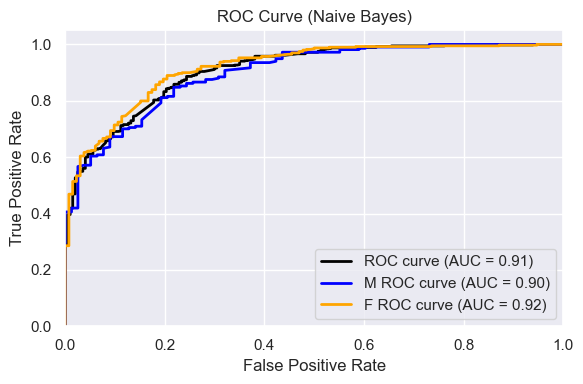

In [141]:
# Plot ROC Curve
roc_auc1 = df_results1.query('metric == "auc"')['mean'].values[0].item()
roc_auc1_m = df_results1_m.query('metric == "auc"')['mean'].values[0].item()
roc_auc1_f = df_results1_f.query('metric == "auc"')['mean'].values[0].item()

plt.figure(figsize=(6, 4))
plt.plot(fpr1, tpr1, color="black", lw=2, label=f"ROC curve (AUC = {roc_auc1:.2f})")
plt.plot(fpr1_m, tpr1_m, color="blue", lw=2, label=f"M ROC curve (AUC = {roc_auc1_m:.2f})")
plt.plot(fpr1_f, tpr1_f, color="orange", lw=2, label=f"F ROC curve (AUC = {roc_auc1_f:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Naive Bayes)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curve_nb_210625.png')
plt.show()

In [142]:
# include the gender and the ML model
df_results1 = df_results1.assign(model='Naive Bayes').assign(gender='all')
df_results1_m = df_results1_m.assign(model='Naive Bayes').assign(gender='male')
df_results1_f = df_results1_f.assign(model='Naive Bayes').assign(gender='female')

### 6.1.1 Feature extraction from Naive Bayes model

In [143]:
# extract all the feature strings from the fitted pipeline
all_feature_names = pipe1.named_steps['count_vectorizer'].get_feature_names_out()

# filter to single token features
features_single_token = np.array([feature_name for feature_name in all_feature_names if len(feature_name.split(' ')) == 1])

single_token_features_mask = np.array([1 if len(feature_name.split(' ')) == 1 else 0 for feature_name in all_feature_names])


In [144]:
# log probabilities of all the features
# log probability of each token conditioned on a given class
log_probs_neg_class = pipe1.named_steps['nb_mn'].feature_log_prob_[0, :]
log_probs_pos_class = pipe1.named_steps['nb_mn'].feature_log_prob_[1, :]

probs_neg_class = np.exp(log_probs_neg_class)
probs_pos_class = np.exp(log_probs_pos_class)

In [145]:
I = np.identity(6588)

In [146]:
k = 3000

probs_pos_class = pipe1.named_steps['nb_mn'].predict_proba(I)[:, 1]
probs_neg_class = pipe1.named_steps['nb_mn'].predict_proba(I)[:, 0]

# find features that are most predictive each class
topk_pos_features = all_feature_names[np.argsort(probs_pos_class)[::-1]]
topk_neg_features = all_feature_names[np.argsort(probs_neg_class)[::-1]]

In [147]:
topk_pos_features = [feature_name for feature_name in topk_pos_features if len(feature_name.split(' ')) == 1][:50]
topk_neg_features = [feature_name for feature_name in topk_neg_features if len(feature_name.split(' ')) == 1][:50]

In [148]:
# find the probabilities of each of these features
topk_pos_probs = probs_pos_class[np.argsort(probs_pos_class)[::-1]]
topk_neg_probs = probs_neg_class[np.argsort(probs_neg_class)[::-1]]

## 6.2. Rule-based classifier

Approach
1) Features selected from Naive Bayes algorithm using $log\left(P(t|c)\right)$ for class $c$ and feature $t$
2) For each of the features, compute the difference between the log probabilities across the two classes
3) Order features from largest to smallest based on this difference
4) Choose the top k and bottom k features
5) To classify first define $W = \log\left(P(c=1)\right) - \log\left(P(c=0)\right) + \sum_w\left[ \log\left( P(w | c=1)\right) - \log\left( P(w | c=0) \right) \right]$
where the summation is over all tokens $w$ in the text. If $W > 0$ then we predict 1 and 0 otherwise

In [149]:
# proportion of positive classes in training data
Pc1 = y_both_train_binary.mean().item()
Pc0 = 1 - Pc1

In [150]:
# extract all the feature strings from the fitted pipeline
all_feature_names = pipe1.named_steps['count_vectorizer'].get_feature_names_out()

# filter to single token features
features_single_token = np.array([feature_name for feature_name in all_feature_names if len(feature_name.split(' ')) == 1])

In [151]:
# all the feature log probabilities
feature_log_probs = np.array([list(pipe1.predict_log_proba([feature_name])[0]) for feature_name in features_single_token])

# find the differences
log_prob_diffs = feature_log_probs[:, 1] - feature_log_probs[:, 0]

# rank the features based on this difference
ranked_feature_indices = np.argsort(log_prob_diffs)[::-1]

In [240]:
# top and bottom k features
k = 64

top_k_features = features_single_token[ranked_feature_indices[:k]]
low_k_features = features_single_token[ranked_feature_indices[-k:]]

top_k_feature_probs = log_prob_diffs[ranked_feature_indices[:k]]
low_k_feature_probs = log_prob_diffs[ranked_feature_indices[-k:]]

feature_score_mapping_top = dict(zip(top_k_features, top_k_feature_probs))
feature_score_mapping_low = dict(zip(low_k_features, low_k_feature_probs))

### 6.2.1. Feature importances

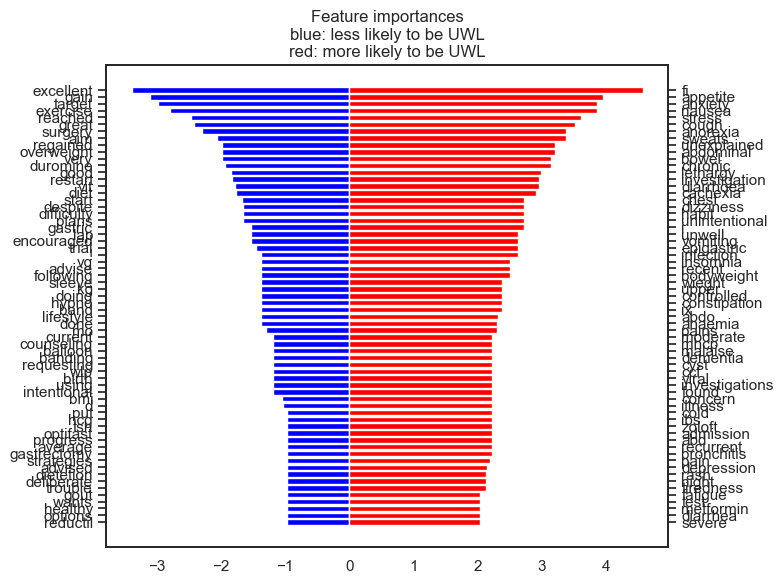

In [241]:
# create a bar chart showing the top and bottom k features
import matplotlib.pyplot as plt
import numpy as np

# Create position indexes for features
y_pos = np.arange(k)
bar_height = 0.8

fig, ax = plt.subplots(figsize=(8, 6))

# Plot first set
ax.barh(y_pos, low_k_feature_probs, height=bar_height, color='blue')

# Plot second set
ax.barh(y_pos, top_k_feature_probs[::-1], height=bar_height, color='red')

# Labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(low_k_features)

# Right y-axis with different labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())  # match y-limits
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_k_features[::-1])

plt.title('Feature importances\nblue: less likely to be UWL\nred: more likely to be UWL')
plt.tight_layout()
plt.savefig('../outputs/210625/feature_importances_32_rb.png')
plt.xlabel('')
plt.show()

### 6.2.2. Definition of classifier

In [242]:
def rule_based_classifier(text, pos_tokens_all, neg_tokens_all):
    """
    Rule-based classifier function. Takes a reason for encounter text and assigns
    a binary value based on whether it is likely to be a UWL encounter or not

    Parameters
    ----------
    text (str) : reason for encounter text
    pos_tokens_all (list of str) : tokens indicating a likely UWL encounter
    neg_tokens_all (list of str) : tokens indicating a likely non-UWL encounter

    Returns
    -------
    score (float) : the score produced by the model (not a probability)
    label (int) : 1 if predicting UWL, 0 if not
    """
    # split the text into tokens
    tokens = text.lower().split(' ')

    # find the positive tokens
    pos_tokens = set(tokens).intersection(pos_tokens_all)

    # find the negative tokens
    neg_tokens = set(tokens).intersection(neg_tokens_all)

    # assign scores to each set of tokens
    pos_token_scores = [feature_score_mapping_top[token] for token in pos_tokens]
    neg_token_scores = [feature_score_mapping_low[token] for token in neg_tokens]

    # calculate the final score
    score = Pc1 - Pc0 + np.sum(pos_token_scores) + np.sum(neg_token_scores)
    
    label = 1 if score > 0 else 0
    
    return score, label

### 6.2.3. Performance evaluation

In [243]:
y_both_train_pred = np.array([rule_based_classifier(text, top_k_features, low_k_features) for text in X_both_train])
y_m_test_pred = np.array([rule_based_classifier(text, top_k_features, low_k_features) for text in X_m_test])
y_f_test_pred = np.array([rule_based_classifier(text, top_k_features, low_k_features) for text in X_f_test])
y_both_test_pred = np.array([rule_based_classifier(text, top_k_features, low_k_features) for text in X_both_test])

In [244]:
fpr, tpr, threshold = roc_curve(y_both_train_binary, y_both_train_pred[:, 0])

In [246]:
roc_auc_score(y_both_test_binary, y_both_test_pred[:, 0])

np.float64(0.7782399163721087)

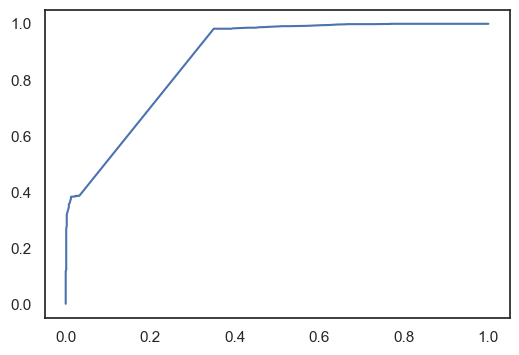

In [247]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.show()

In [248]:
sample = list(zip(y_both_test_binary, y_both_test_pred[:, 1]))
results1b_all = calculate_bootstrap_ci(sample, num_bootstrap_samples=1024, ci=0.95, threshold=0)

df_results1b = pd.DataFrame(results1b_all).T.rename(columns={0: 'mean', 1: 'left_ci', 2: 'right_ci'})
df_results1b.index.name = 'metric'
df_results1b.reset_index(inplace=True)

# AUC values should be nan since we don't have probs for rule-based classifier
df_results1b.iloc[0, 1] = np.nan
df_results1b.iloc[0, 2] = np.nan
df_results1b.iloc[0, 3] = np.nan

df_results1b.assign(model='Rule-based').assign(gender='both')

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1514.06it/s]


,metric,mean,left_ci,right_ci,model,gender
0,auc,NaN,NaN,NaN,Rule-based,both
1,ppv,0.811306,0.782178,0.839716,Rule-based,both
2,npv,0.927749,0.862500,0.985075,Rule-based,both
3,sensitivity,0.991128,0.982818,0.998252,Rule-based,both
4,specificity,0.330137,0.269608,0.397790,Rule-based,both


In [249]:
sample = list(zip(y_f_test_binary, y_f_test_pred[:, 1]))
results1b_f = calculate_bootstrap_ci(sample, num_bootstrap_samples=1024, ci=0.95, threshold=0)

df_results1b_f = pd.DataFrame(results1b_f).T.rename(columns={0: 'mean', 1: 'left_ci', 2: 'right_ci'})
df_results1b_f.index.name = 'metric'
df_results1b_f.reset_index(inplace=True)
#df_results1b_f = df_results1b_f.iloc[1:, :].reset_index()

# AUC values should be nan since we don't have probs for rule-based classifier
df_results1b_f.iloc[0, 1] = np.nan
df_results1b_f.iloc[0, 2] = np.nan
df_results1b_f.iloc[0, 3] = np.nan

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1763.05it/s]


In [250]:
sample = list(zip(y_m_test_binary, y_m_test_pred[:, 1]))
results1b_m = calculate_bootstrap_ci(sample, num_bootstrap_samples=1024, ci=0.95, threshold=0)

df_results1b_m = pd.DataFrame(results1b_m).T.rename(columns={0: 'mean', 1: 'left_ci', 2: 'right_ci'})
df_results1b_m.index.name = 'metric'
df_results1b_m.reset_index(inplace=True)

# AUC values should be nan since we don't have probs for rule-based classifier
df_results1b_m.iloc[0, 1] = np.nan
df_results1b_m.iloc[0, 2] = np.nan
df_results1b_m.iloc[0, 3] = np.nan

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 2099.27it/s]


In [251]:
df_results1b = df_results1b.assign(model='Rule-based').assign(gender='overall')
df_results1b_f = df_results1b_f.assign(model='Rule-based').assign(gender='female')
df_results1b_m = df_results1b_m.assign(model='Rule-based').assign(gender='male')

In [253]:
df_results1b_f

,metric,mean,left_ci,right_ci,model,gender
0,auc,NaN,NaN,NaN,Rule-based,female
1,ppv,0.821302,0.784969,0.856250,Rule-based,female
2,npv,0.921056,0.830508,0.982456,Rule-based,female
3,sensitivity,0.990154,0.977941,0.997579,Rule-based,female
4,specificity,0.347639,0.272727,0.428571,Rule-based,female


## 6.3. Decision tree classifier

In [166]:
from sklearn.tree import DecisionTreeClassifier

In [167]:
# ML modelling pipeline
pipe2 = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), analyzer='word', token_pattern=None)), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('dtc', DecisionTreeClassifier())
])

In [168]:
# grid search for optimal hyperparameters
params = {'dtc__max_depth': np.arange(1, 2048), 
          'dtc__max_features': [8, 16, 32, 64, 128, 256, 512, 1024, 1200, 1400, 1600],
          'dtc__min_samples_split': [2, 4, 6, 8, 16]}

clf2 = RandomizedSearchCV(pipe2, params, scoring='roc_auc')

search2 = clf2.fit(X_both_train, y_both_train_binary)

In [169]:
# ML modelling pipeline: best params
pipe2 = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), analyzer='word', token_pattern=None)), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('dtc', DecisionTreeClassifier(min_samples_split=search2.best_params_['dtc__min_samples_split'], 
                                   max_features=search2.best_params_['dtc__max_features'], 
                                   max_depth=search2.best_params_['dtc__max_depth']))
])

In [170]:
df_results2, fpr2, tpr2, threshold2 = run_performance_estimate_pipeline(pipe2, 
                                                                        X_both_train, 
                                                                        y_both_train_binary, 
                                                                        X_both_test, 
                                                                        y_both_test_binary, 
                                                                        cv=10, 
                                                                        scoring=scoring, 
                                                                        num_bootstrap_samples=1024, 
                                                                        ci=0.95)
# by gender
# male
df_results2_m, fpr2_m, tpr2_m, threshold2_m = run_performance_estimate_pipeline(pipe2, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_m_test, 
                                                                                y_m_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

# female
df_results2_f, fpr2_f, tpr2_f, threshold2_f = run_performance_estimate_pipeline(pipe2, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_f_test, 
                                                                                y_f_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1516.44it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 2114.35it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1781.41it/s]


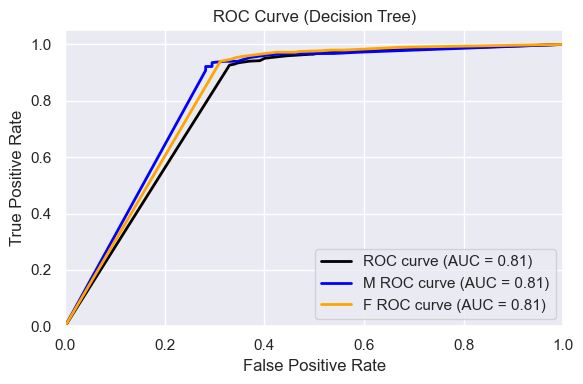

In [171]:
# Plot ROC Curve
roc_auc2 = df_results2.query('metric == "auc"')['mean'].values[0].item()
roc_auc2_m = df_results2_m.query('metric == "auc"')['mean'].values[0].item()
roc_auc2_f = df_results2_f.query('metric == "auc"')['mean'].values[0].item()

plt.figure(figsize=(6, 4))
plt.plot(fpr2, tpr2, color="black", lw=2, label=f"ROC curve (AUC = {roc_auc2:.2f})")
plt.plot(fpr2_m, tpr2_m, color="blue", lw=2, label=f"M ROC curve (AUC = {roc_auc2:.2f})")
plt.plot(fpr2_f, tpr2_f, color="orange", lw=2, label=f"F ROC curve (AUC = {roc_auc2:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Decision Tree)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curve_dt_210625.png')
plt.show()

In [172]:
# include the gender and the ML model
df_results2 = df_results2.assign(model='Decision Tree').assign(gender='all')
df_results2_m = df_results2_m.assign(model='Decision Tree').assign(gender='male')
df_results2_f = df_results2_f.assign(model='Decision Tree').assign(gender='female')

## 6.4. RandomForests

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [174]:
pipe3 = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), analyzer='word', token_pattern=None)), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('rf', RandomForestClassifier())
])

In [175]:
# grid search for optimal hyperparameters
params = {'rf__max_depth': np.arange(1, 2048), 
          'rf__max_features': np.arange(8, 2048),
          'rf__min_samples_split': np.arange(2, 128)}

clf3 = RandomizedSearchCV(pipe3, params, scoring='roc_auc')

search3 = clf3.fit(X_both_train, y_both_train_binary)

In [176]:
pipe3 = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), analyzer='word', token_pattern=None)), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('rf', RandomForestClassifier(max_depth=search3.best_params_['rf__max_depth'], 
                                  max_features=search3.best_params_['rf__max_features'], 
                                  min_samples_split=search3.best_params_['rf__min_samples_split']))
])

In [177]:
df_results3, fpr3, tpr3, threshold3 = run_performance_estimate_pipeline(pipe3, 
                                                                        X_both_train, 
                                                                        y_both_train_binary, 
                                                                        X_both_test, 
                                                                        y_both_test_binary, 
                                                                        cv=10, 
                                                                        scoring=scoring, 
                                                                        num_bootstrap_samples=1024, 
                                                                        ci=0.95)

df_results3_m, fpr3_m, tpr3_m, threshold3_m = run_performance_estimate_pipeline(pipe3, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_m_test, 
                                                                                y_m_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

# female
df_results3_f, fpr3_f, tpr3_f, threshold3_f = run_performance_estimate_pipeline(pipe3, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_f_test, 
                                                                                y_f_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1405.02it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 2045.88it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1665.01it/s]


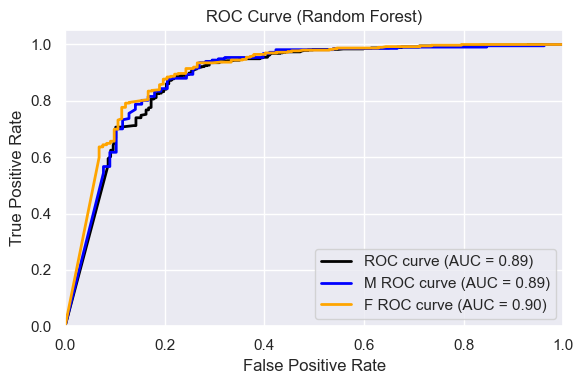

In [178]:
# Plot ROC Curve
roc_auc3 = df_results3.query('metric == "auc"')['mean'].values[0].item()
roc_auc3_m = df_results3_m.query('metric == "auc"')['mean'].values[0].item()
roc_auc3_f = df_results3_f.query('metric == "auc"')['mean'].values[0].item()

plt.figure(figsize=(6, 4))
plt.plot(fpr3, tpr3, color="black", lw=2, label=f"ROC curve (AUC = {roc_auc3:.2f})")
plt.plot(fpr3_m, tpr3_m, color="blue", lw=2, label=f"M ROC curve (AUC = {roc_auc3_m:.2f})")
plt.plot(fpr3_f, tpr3_f, color="orange", lw=2, label=f"F ROC curve (AUC = {roc_auc3_f:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curve_rf_210625.png')
plt.show()

In [179]:
# include the gender and the ML model
df_results3 = df_results3.assign(model='RandomForest').assign(gender='all')
df_results3_m = df_results3_m.assign(model='RandomForest').assign(gender='male')
df_results3_f = df_results3_f.assign(model='RandomForest').assign(gender='female')

## 6.5. Logistic regression classifier

Findings:
- Out of 6360 features in original pipeline, only require 243 for l1 logistic regression

In [180]:
from sklearn.linear_model import LogisticRegression

### 6.5.1. Train the model

In [181]:
pipe4 = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), analyzer='word', token_pattern=None)), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('lr', LogisticRegression())
])

In [182]:
params = {'lr__penalty': ['l1'], 'lr__solver': ['liblinear']}

In [183]:
clf4 = GridSearchCV(pipe4, params, scoring='roc_auc')

search4 = clf4.fit(X_both_train, y_both_train_binary)

In [184]:
pipe4 = Pipeline([
    ('count_vectorizer', CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), analyzer='word', token_pattern=None)), 
    ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ('lr', LogisticRegression(penalty='l1', solver='liblinear'))
])

In [185]:
df_results4, fpr4, tpr4, threshold4 = run_performance_estimate_pipeline(pipe4, 
                                                                        X_both_train, 
                                                                        y_both_train_binary, 
                                                                        X_both_test, 
                                                                        y_both_test_binary, 
                                                                        cv=10, 
                                                                        scoring=scoring, 
                                                                        num_bootstrap_samples=1024, 
                                                                        ci=0.95)

df_results4_m, fpr4_m, tpr4_m, threshold4_m = run_performance_estimate_pipeline(pipe4, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_m_test, 
                                                                                y_m_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

# female
df_results4_f, fpr4_f, tpr4_f, threshold4_f = run_performance_estimate_pipeline(pipe4, 
                                                                                X_both_train, 
                                                                                y_both_train_binary, 
                                                                                X_f_test, 
                                                                                y_f_test_binary, 
                                                                                cv=10, 
                                                                                scoring=scoring, 
                                                                                num_bootstrap_samples=1024, 
                                                                                ci=0.95)

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1398.87it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 2026.82it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1653.30it/s]


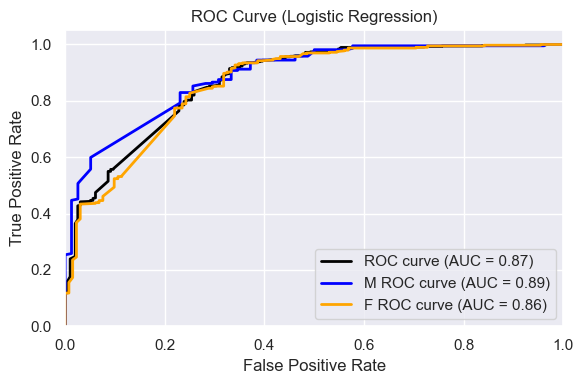

In [186]:
# Plot ROC Curve
roc_auc4 = df_results4.query('metric == "auc"')['mean'].values[0].item()
roc_auc4_m = df_results4_m.query('metric == "auc"')['mean'].values[0].item()
roc_auc4_f = df_results4_f.query('metric == "auc"')['mean'].values[0].item()

plt.figure(figsize=(6, 4))
plt.plot(fpr4, tpr4, color="black", lw=2, label=f"ROC curve (AUC = {roc_auc4:.2f})")
plt.plot(fpr4_m, tpr4_m, color="blue", lw=2, label=f"M ROC curve (AUC = {roc_auc4_m:.2f})")
plt.plot(fpr4_f, tpr4_f, color="orange", lw=2, label=f"F ROC curve (AUC = {roc_auc4_f:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate") 
plt.title("ROC Curve (Logistic Regression)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curve_lr_210625.png')
plt.show()

In [187]:
# include the gender and the ML model
df_results4 = df_results4.assign(model='Logistic Regression').assign(gender='all')
df_results4_m = df_results4_m.assign(model='Logistic Regression').assign(gender='male')
df_results4_f = df_results4_f.assign(model='Logistic Regression').assign(gender='female')

### 6.5.2. Feature importances

In [188]:
# which features are relevant?
coefs4 = pipe4['lr'].coef_

# all the features from the model
feature_names4 = pipe4['count_vectorizer'].get_feature_names_out()
main_features4 = np.where(coefs4 != 0)[1] # features that have non-zero coefficients

# coefficients and corresponding features
main_coefs4 = coefs4[0, main_features4]
main_feature_names4 = feature_names4[main_features4]

# sort these
sorted_indexes4 = np.argsort(main_coefs4)[::-1]
main_coefs_sorted4 = main_coefs4[sorted_indexes4]
main_feature_names_sorted4 = main_feature_names4[sorted_indexes4]

# separate out into positive and negative features
main_coefs_positive4 = main_coefs_sorted4[main_coefs_sorted4 > 0]
main_features_positive4 = main_feature_names_sorted4[main_coefs_sorted4 > 0]

main_coefs_negative4 = main_coefs_sorted4[main_coefs_sorted4 < 0]
main_features_negative4 = main_feature_names_sorted4[main_coefs_sorted4 < 0]

In [189]:
num_features_to_plot = 32

coefs1 = main_coefs_sorted4[:num_features_to_plot]
coefs2 = main_coefs_sorted4[-num_features_to_plot:][::-1]

labels1 = main_feature_names_sorted4[:num_features_to_plot]
labels2 = main_feature_names_sorted4[-num_features_to_plot:][::-1]

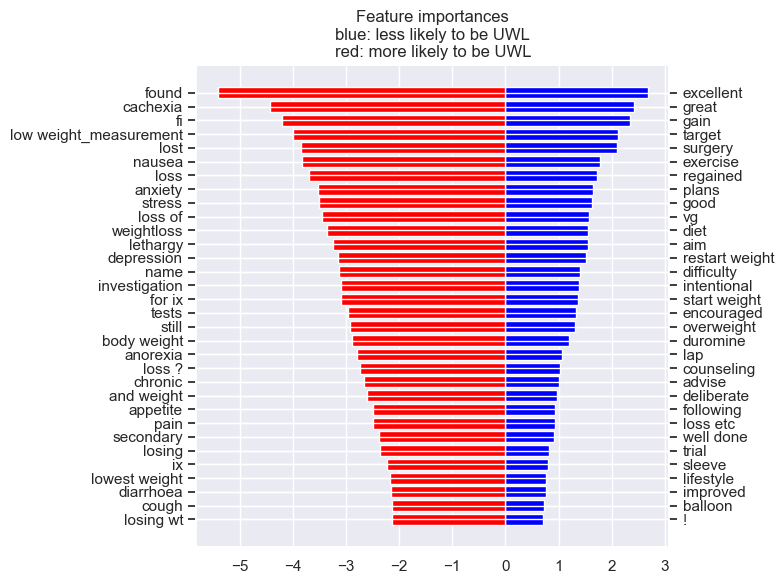

In [190]:
import matplotlib.pyplot as plt
import numpy as np

# Create position indexes for features
y_pos = np.arange(num_features_to_plot)
bar_height = 0.8

fig, ax = plt.subplots(figsize=(8, 6))

# Plot first set
ax.barh(y_pos, coefs1[::-1], height=bar_height, color='blue')

# Plot second set
ax.barh(y_pos, coefs2[::-1], height=bar_height, color='red')

# Labels and ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(labels1[::-1])

# Right y-axis with different labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())  # match y-limits
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels2[::-1])

plt.title('Feature importances\nblue: less likely to be UWL\nred: more likely to be UWL')
plt.tight_layout()
plt.savefig('../outputs/210625/feature_importances_32_lr.png')
plt.show()


## 6.6. ClinicalBERT

In [191]:
import yaml

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch

from sklearn.metrics import confusion_matrix

import evaluate
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

from transformers import DataCollatorWithPadding

In [192]:
torch.mps.empty_cache()

# Load the YAML file
with open("/Users/alexlee/Desktop/Coding/ds_projects/info.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access the token
access_token = config["api"]["access_token"]

In [193]:
folder = '/Users/alexlee/Desktop/Projects/data_connect/uwl_phenotyping/data'

# actual data
df_all_temp = (
    pd.read_csv(f'{folder}/reasons_cleaned_230325.csv')
    .assign(label=lambda df_: df_.label - 1)
    .assign(label=lambda df_: df_.label_binary)
)

In [194]:
# for testing performance with gender
df_train = df_all_gender.query('source == "nps"')
df_test = df_all_gender.query('source == "patron"')

# for testing performance ignoring gender
df_train_all = df_train.loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()
df_test_all = df_test.loc[:, ['text', 'label', 'label_binary', 'source', 'text_processed']].drop_duplicates()

In [195]:
# train on nps and test on patron: old. Use the training and test sets from df_all_gender
df_train = df_all_temp.query('data_source=="medicineinsight"')
df_test = df_all_temp.query('data_source=="patron"')

In [196]:
df_train = df_all_gender.query('source == "nps"').assign(label=lambda df_: df_.label_binary.astype(int))
df_test = df_all_gender.query('source == "patron"').assign(label=lambda df_: df_.label_binary.astype(int))

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Remove index column if it exists
for dataset in [train_dataset, test_dataset]:
    if "__index__" in dataset.column_names:
        dataset = dataset.remove_columns(["__index__"])

# Create a DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [197]:
# standard bert tokeniser
model_clinical = "emilyalsentzer/Bio_ClinicalBERT"
model_clinical = "medicalai/ClinicalBERT"
model_bert_base = "google-bert/bert-base-cased"

model_name = model_clinical

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    """
    examples: datasets.arrow_dataaset.Dataset
    """
    # tokenise is applied to the processed text rather than the original text
    return tokenizer(examples["text_processed"], padding="max_length", truncation=True)
    
tokenized_datasets = dataset.map(tokenize_function, batched=True)

hf_train_dataset = tokenized_datasets["train"].shuffle(seed=40).select(range(1600))
hf_eval_dataset = tokenized_datasets["train"].shuffle(seed=40).select(range(1600, 2358))

Map:   0%|          | 0/2557 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/827 [00:00<?, ? examples/s]

In [198]:
# this loads the pre-trained model from huggingface and specifies the parameters, e.g., number of output labels
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, torch_dtype="auto")

# 'freezes' all the layers of the network so that they are not updated during training: also doesn't work very well
#for param in model.base_model.parameters():
#    param.requires_grad = False
    
# move to mps 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# where to store the results of the training runs
training_args = TrainingArguments(output_dir="test_trainer")

# define the metric to calculate during training
metric = evaluate.load("accuracy")

# given a tuple of predictions and labels
# this function computes and returns the given metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [199]:
training_args = TrainingArguments(
    output_dir="bert_phenotyping_classifier",
    eval_strategy="steps",
    logging_strategy='steps',    
    num_train_epochs=2,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    push_to_hub=False,
    logging_steps=5,
    save_strategy="no",
    logging_dir=None,
    report_to=None,  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_train_dataset,
    eval_dataset=hf_eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/7h/4cq59zrd6vb2jqwxh3wdk3nw0000gn/T/ipykernel_87171/1377928591.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [200]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
huggingface/tokenizers: 

Step,Training Loss,Validation Loss,Accuracy
5,0.634300,0.640397,0.643799
10,0.590000,0.655445,0.643799
15,0.564600,0.595506,0.643799
20,0.614800,0.537866,0.736148
25,0.525200,0.582304,0.732190
30,0.513800,0.468579,0.766491
35,0.409500,0.438774,0.795515
40,0.438800,0.525817,0.771768
45,0.486300,0.402696,0.823219
50,0.353000,0.398367,0.823219


TrainOutput(global_step=200, training_loss=0.3194693736732006, metrics={'train_runtime': 72.1545, 'train_samples_per_second': 44.349, 'train_steps_per_second': 2.772, 'total_flos': 20383420968192.0, 'train_loss': 0.3194693736732006, 'epoch': 2.0})

In [201]:
logs = trainer.state.log_history

train_loss = []
eval_loss = []

eval_acc = []

for log in logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_acc.append(log['eval_accuracy'])

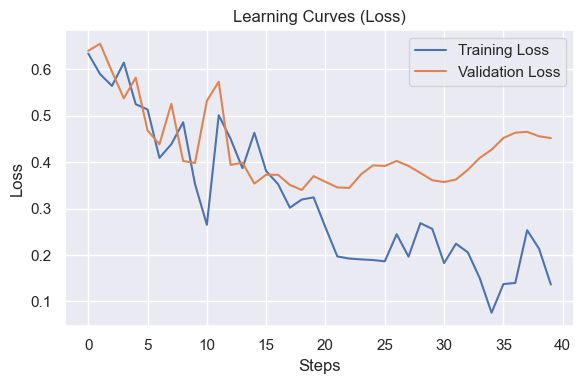

In [202]:
plt.figure(figsize=(6, 4))

plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Learning Curves (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../outputs/210625/loss_curves_clinical_bert_210625.png')
plt.show()

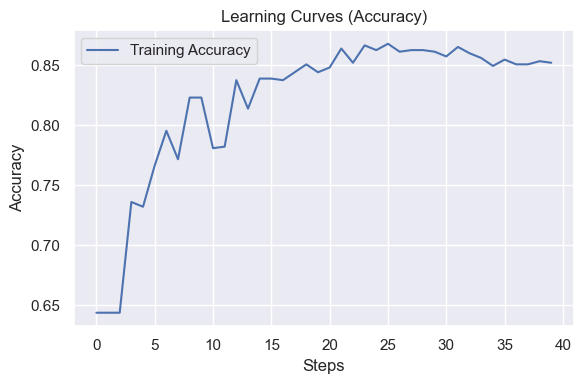

In [203]:
plt.figure(figsize=(6, 4))

plt.plot(eval_acc, label="Training Accuracy")

plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Learning Curves (Accuracy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../outputs/210625/accuracy_curves_clinical_bert_210625.png')
plt.show()

In [204]:
# function that makes predictions given a model and texts
def predict(texts, model):
    # Tokenize the input text
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    # Run the model
    with torch.no_grad():
        device = torch.device("cpu")  # Ensure using MPS
        model = model.to(device)
        inputs = inputs.to(device)
        outputs = model(**inputs)

    # Get predictions
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predictions = torch.argmax(probabilities, dim=-1).tolist()

    return predictions, probabilities

In [205]:
# apply prediction function to the test data
texts_test = dataset['test']['text_processed']
texts_test_m = dataset.filter(lambda example: example['gender'] == 2)['test']['text_processed']
texts_test_f = dataset.filter(lambda example: example['gender'] == 1)['test']['text_processed']

preds_test5, probs_test5 = predict(texts_test, model)
preds_test5_m, probs_test5_m = predict(texts_test_m, model)
preds_test5_f, probs_test5_f = predict(texts_test_f, model)

# convert predictions to np.array
preds_test5 = np.array(preds_test5)
preds_test5_m = np.array(preds_test5_m)
preds_test5_f = np.array(preds_test5_f)

# the true labels
true_labels_test = np.array(dataset['test']['label'])
true_labels_test_f = np.array(dataset.filter(lambda example: example["gender"] == 1)['test']['label'])
true_labels_test_m = np.array(dataset.filter(lambda example: example["gender"] == 2)['test']['label'])

# overall accuracy
acc_test5 = (true_labels_test == preds_test5).mean()
acc_test5_m = (true_labels_test_m == preds_test5_m).mean()
acc_test5_f = (true_labels_test_f == preds_test5_f).mean()

# create a confusion matrix
cm_test = confusion_matrix(true_labels_test, preds_test5)
cm_test_f = confusion_matrix(true_labels_test_f, preds_test5_f)
cm_test_m = confusion_matrix(true_labels_test_m, preds_test5_m)

# ROC curves
fpr5, tpr5, threshold5 = roc_curve(true_labels_test, probs_test5[:, 1])
fpr5_m, tpr5_m, threshold5_m = roc_curve(true_labels_test_m, probs_test5_m[:, 1])
fpr5_f, tpr5_f, threshold5_f = roc_curve(true_labels_test_f, probs_test5_f[:, 1])

roc_auc5 = roc_auc_score(true_labels_test, probs_test5[:, 1])
roc_auc5_m = roc_auc_score(true_labels_test_m, probs_test5_m[:, 1])
roc_auc5_f = roc_auc_score(true_labels_test_f, probs_test5_f[:, 1])

Filter:   0%|          | 0/2557 [00:00<?, ? examples/s]

Filter:   0%|          | 0/827 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2557 [00:00<?, ? examples/s]

Filter:   0%|          | 0/827 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2557 [00:00<?, ? examples/s]

Filter:   0%|          | 0/827 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2557 [00:00<?, ? examples/s]

Filter:   0%|          | 0/827 [00:00<?, ? examples/s]

In [206]:
texts_test = dataset['test']['text_processed']
preds_test5, probs_test5 = predict(texts_test, model)

sample5 = list(zip(true_labels_test, probs_test5[:, 1]))
sample5_m = list(zip(true_labels_test_m, probs_test5_m[:, 1]))
sample5_f = list(zip(true_labels_test_f, probs_test5_f[:, 1]))

results_pipe5 = calculate_bootstrap_ci(sample5, num_bootstrap_samples=1024, ci=0.95)
results_pipe5_m = calculate_bootstrap_ci(sample5_m, num_bootstrap_samples=1024, ci=0.95)
results_pipe5_f = calculate_bootstrap_ci(sample5_f, num_bootstrap_samples=1024, ci=0.95)

Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1303.90it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 2000.39it/s]


Calculating bootstrap estimates for 1024 bootstrap samples


Calculating estimates: 100%|██████████████| 1024/1024 [00:00<00:00, 1626.98it/s]


In [207]:
df_results5 = pd.DataFrame(results_pipe5).T.rename(columns={0: 'mean', 1: 'left_ci', 2: 'right_ci'})
df_results5.index.name = 'metric'
df_results5.reset_index(inplace=True)

df_results5_f = pd.DataFrame(results_pipe5_f).T.rename(columns={0: 'mean', 1: 'left_ci', 2: 'right_ci'})
df_results5_f.index.name = 'metric'
df_results5_f.reset_index(inplace=True)

df_results5_m = pd.DataFrame(results_pipe5_m).T.rename(columns={0: 'mean', 1: 'left_ci', 2: 'right_ci'})
df_results5_m.index.name = 'metric'
df_results5_m.reset_index(inplace=True)

In [208]:
# include the gender and the ML model
df_results5 = df_results5.assign(model='ClinicalBERT').assign(gender='all')
df_results5_m = df_results5_m.assign(model='ClinicalBERT').assign(gender='male')
df_results5_f = df_results5_f.assign(model='ClinicalBERT').assign(gender='female')

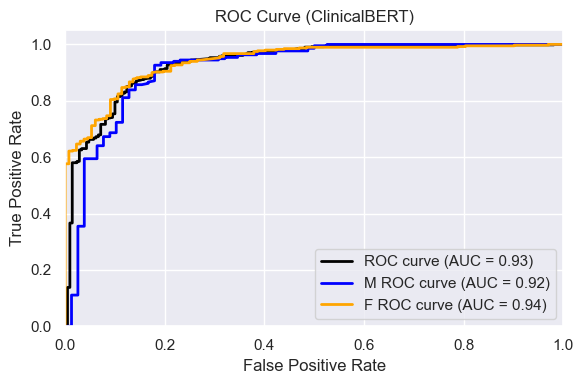

In [209]:
# Plot ROC Curve
roc_auc5 = df_results5.query('metric == "auc"')['mean'].values[0].item()
roc_auc5_m = df_results5_m.query('metric == "auc"')['mean'].values[0].item()
roc_auc5_f = df_results5_f.query('metric == "auc"')['mean'].values[0].item()

plt.figure(figsize=(6, 4))
plt.plot(fpr5, tpr5, color="black", lw=2, label=f"ROC curve (AUC = {roc_auc5:.2f})")
plt.plot(fpr5_m, tpr5_m, color="blue", lw=2, label=f"M ROC curve (AUC = {roc_auc5_m:.2f})")
plt.plot(fpr5_f, tpr5_f, color="orange", lw=2, label=f"F ROC curve (AUC = {roc_auc5_f:.2f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ClinicalBERT)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curve_cb_210625.png')
plt.show()

# 7. Combine results

Combine all the results from all classifiers and the subgroups into a single dataframe

In [210]:
import matplotlib.patches as mpatches

In [ ]:
df_results1b

In [212]:
colour_mapping = dict(zip(['Rule-based', 'Naive Bayes', 'Decision Tree', 
                           'Random Forest', 'Logistic Regression', 'ClinicalBERT'], 
                          sns.color_palette('Set2')[:6]))

colour_mapping_m = dict(zip(['Rule-based', 'Naive Bayes', 'Decision Tree', 
                             'Random Forest', 'Logistic Regression', 'ClinicalBERT'], 
                          sns.color_palette('Paired')[::2]))

colour_mapping_f = dict(zip(['Rule-based', 'Naive Bayes', 'Decision Tree', 
                             'Random Forest', 'Logistic Regression', 'ClinicalBERT'], 
                          sns.color_palette('Paired')[1::2]))

df_results_overall = (
    pd.concat([
        df_results1b.assign(classifier="Rule-based"),
        df_results1.assign(classifier='Naive Bayes'),
        df_results2.assign(classifier='Decision Tree'),
        df_results3.assign(classifier='Random Forest'),
        df_results4.assign(classifier='Logistic Regression'),
        df_results5.assign(classifier='ClinicalBERT')
    ])
    .reset_index()
    .rename(columns={'index': 'order'})
    .assign(
        classifier_num=lambda df_: df_.groupby('classifier').ngroup(),
        y_value=lambda df_: df_['order'] + df_['classifier_num'] * 0.16,
        colour=lambda df_: df_.classifier.map(colour_mapping)
    )
)

df_results_m = (
    pd.concat([
        df_results1b_m.assign(classifier='Rule-based'),
        df_results1_m.assign(classifier='Naive Bayes'),
        df_results2_m.assign(classifier='Decision Tree'),
        df_results3_m.assign(classifier='Random Forest'),
        df_results4_m.assign(classifier='Logistic Regression'),
        df_results5_m.assign(classifier='ClinicalBERT')
    ])
    .reset_index()
    .rename(columns={'index': 'order'})
    .assign(
        classifier_num=lambda df_: df_.groupby('classifier').ngroup(),
        y_value=lambda df_: df_['order'] + df_['classifier_num'] * 0.16,
        colour=lambda df_: df_.classifier.map(colour_mapping_m)
    )
)

df_results_f = (
    pd.concat([
        df_results1b_f.assign(classifier='Rule-based'),
        df_results1_f.assign(classifier='Naive Bayes'),
        df_results2_f.assign(classifier='Decision Tree'),
        df_results3_f.assign(classifier='Random Forest'),
        df_results4_f.assign(classifier='Logistic Regression'),
        df_results5_f.assign(classifier='ClinicalBERT')
    ])
    .reset_index()
    .rename(columns={'index': 'order'})
    .assign(
        classifier_num=lambda df_: df_.groupby('classifier').ngroup(),
        y_value=lambda df_: df_['order'] + df_['classifier_num'] * 0.16,
        colour=lambda df_: df_.classifier.map(colour_mapping_f)
    )
)

In [213]:
df_results_mf = pd.concat([df_results_m.assign(y_value=lambda df_: df_.y_value + 0.05), 
                           df_results_f]).reset_index().iloc[:, 1:]

In [239]:
df_results_overall

,order,metric,mean,left_ci,right_ci,model,gender,classifier,classifier_num,y_value,colour
0,0,auc,NaN,NaN,NaN,Rule-based,overall,Rule-based,5,0.80,"(0.4, 0.7607843137254902, 0.6470588235294118)"
1,1,ppv,0.758060,0.726552,0.788079,Rule-based,overall,Rule-based,5,1.80,"(0.4, 0.7607843137254902, 0.6470588235294118)"
2,2,npv,1.000000,1.000000,1.000000,Rule-based,overall,Rule-based,5,2.80,"(0.4, 0.7607843137254902, 0.6470588235294118)"
3,3,sensitivity,1.000000,1.000000,1.000000,Rule-based,overall,Rule-based,5,3.80,"(0.4, 0.7607843137254902, 0.6470588235294118)"
4,4,specificity,0.070769,0.036697,0.109290,Rule-based,overall,Rule-based,5,4.80,"(0.4, 0.7607843137254902, 0.6470588235294118)"
5,0,auc,0.907828,0.884515,0.930083,Naive Bayes,all,Naive Bayes,3,0.48,"(0.9882352941176471, 0.5529411764705883, 0.384..."
6,1,ppv,0.863598,0.836538,0.889764,Naive Bayes,all,Naive Bayes,3,1.48,"(0.9882352941176471, 0.5529411764705883, 0.384..."
7,2,npv,0.833486,0.765957,0.893617,Naive Bayes,all,Naive Bayes,3,2.48,"(0.9882352941176471, 0.5529411764705883, 0.384..."
8,3,sensitivity,0.961327,0.943958,0.975779,Naive Bayes,all,Naive Bayes,3,3.48,"(0.9882352941176471, 0.5529411764705883, 0.384..."
9,4,specificity,0.560279,0.486631,0.629213,Naive Bayes,all,Naive Bayes,3,4.48,"(0.9882352941176471, 0.5529411764705883, 0.384..."


# 8. Create data visualisations

## 8.1. ROC curves

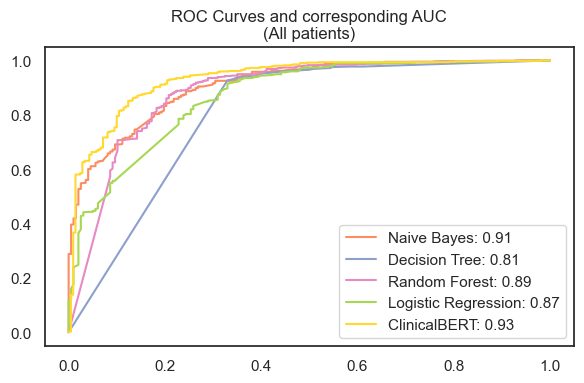

In [214]:
# plot all the roc curves
sns.set_style('white')
plt.figure(figsize=(6, 4))
plt.title("ROC Curves and corresponding AUC\n(All patients)")
plt.plot(fpr1, tpr1, c=colour_mapping['Naive Bayes'], label=f'Naive Bayes: {roc_auc1:.2f}')
plt.plot(fpr2, tpr2, c=colour_mapping['Decision Tree'], label=f'Decision Tree: {roc_auc2:.2f}')
plt.plot(fpr3, tpr3, c=colour_mapping['Random Forest'], label=f'Random Forest: {roc_auc3:.2f}')
plt.plot(fpr4, tpr4, c=colour_mapping['Logistic Regression'], label=f'Logistic Regression: {roc_auc4:.2f}')
plt.plot(fpr5, tpr5, c=colour_mapping['ClinicalBERT'], label=f'ClinicalBERT: {roc_auc5:.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curves_all.png')
plt.show()

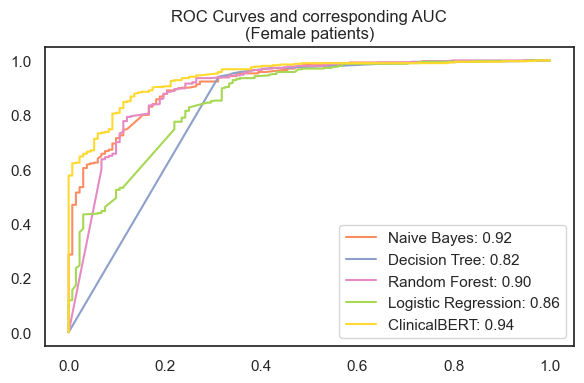

In [215]:
# plot all the roc curves
plt.figure(figsize=(6, 4))
plt.title("ROC Curves and corresponding AUC\n(Female patients)")
plt.plot(fpr1_f, tpr1_f, c=colour_mapping['Naive Bayes'], label=f'Naive Bayes: {roc_auc1_f:.2f}')
plt.plot(fpr2_f, tpr2_f, c=colour_mapping['Decision Tree'], label=f'Decision Tree: {roc_auc2_f:.2f}')
plt.plot(fpr3_f, tpr3_f, c=colour_mapping['Random Forest'], label=f'Random Forest: {roc_auc3_f:.2f}')
plt.plot(fpr4_f, tpr4_f, c=colour_mapping['Logistic Regression'], label=f'Logistic Regression: {roc_auc4_f:.2f}')
plt.plot(fpr5_f, tpr5_f, c=colour_mapping['ClinicalBERT'], label=f'ClinicalBERT: {roc_auc5_f:.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curves_f.png')
plt.show()

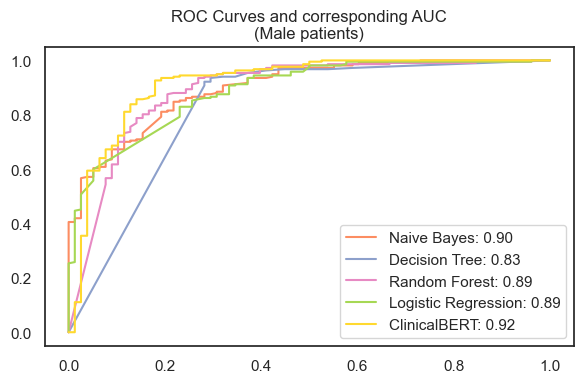

In [216]:
# plot all the roc curves
plt.figure(figsize=(6, 4))
plt.title("ROC Curves and corresponding AUC\n(Male patients)")
plt.plot(fpr1_m, tpr1_m, c=colour_mapping['Naive Bayes'], label=f'Naive Bayes: {roc_auc1_m:.2f}')
plt.plot(fpr2_m, tpr2_m, c=colour_mapping['Decision Tree'], label=f'Decision Tree: {roc_auc2_m:.2f}')
plt.plot(fpr3_m, tpr3_m, c=colour_mapping['Random Forest'], label=f'Random Forest: {roc_auc3_m:.2f}')
plt.plot(fpr4_m, tpr4_m, c=colour_mapping['Logistic Regression'], label=f'Logistic Regression: {roc_auc4_m:.2f}')
plt.plot(fpr5_m, tpr5_m, c=colour_mapping['ClinicalBERT'], label=f'ClinicalBERT: {roc_auc5_m:.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/210625/roc_curves_m.png')
plt.show()

## 8.2. Overall stats for all classifiers

### 8.2.1. Both genders

In [217]:
classifier_order = {'Naive Bayes': 2, 
                    'Random Forest': 1, 
                    'Logistic Regression': 3, 
                    'Decision Tree': 4, 
                    'ClinicalBERT': 5,
                    'Rule-based': 0}

ordered_colour_values = (
    df_results_overall[['classifier', 'colour']]
    .drop_duplicates()
    .reset_index()
    .iloc[:, 1:]
    .assign(classifier_order=lambda df_: df_.classifier.map(classifier_order))
    .sort_values(by='classifier_order')
    .loc[:, ['classifier', 'colour']]
    .values
)

/var/folders/7h/4cq59zrd6vb2jqwxh3wdk3nw0000gn/T/ipykernel_87171/1825401030.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['AUC', 'PPV', 'NPV', 'Sensitivity', 'Specificity'])


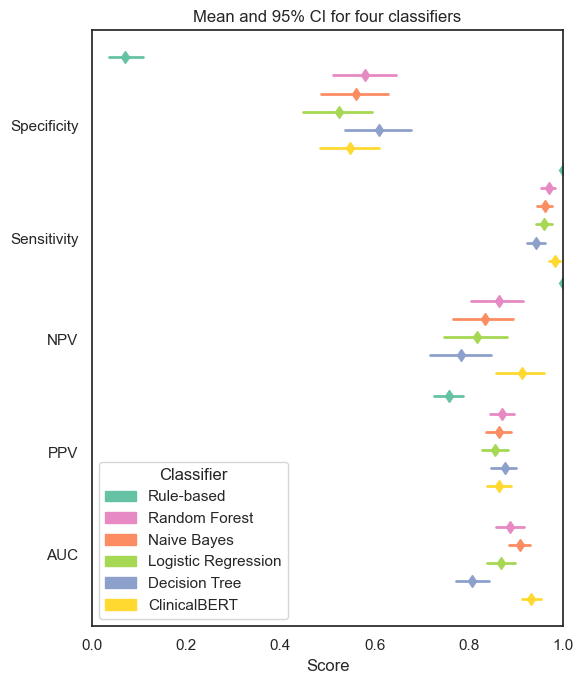

In [218]:
# Set plot style
sns.set(style='white')

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 7))

# Loop through each row to plot
for i, row in df_results_overall.iterrows():
    ax.plot([row['left_ci'], row['right_ci']], [row['y_value']] * 2, color=row['colour'], lw=2)
    ax.plot(row['mean'], row['y_value'], 'd', color=row['colour'])

# Optional: aesthetics
ax.set_xlabel('Score')
ax.set_yticklabels(['AUC', 'PPV', 'NPV', 'Sensitivity', 'Specificity'])
ax.set_yticks([0.4, 1.3, 2.3, 3.2, 4.2])
ax.set_xlim(0, 1)
ax.set_title('Mean and 95% CI for four classifiers')

legend_elements = [
    mpatches.Patch(color=color, label=clf)
    for clf, color in ordered_colour_values
]
ax.legend(handles=legend_elements, title='Classifier')

handles, labels = ax.get_legend_handles_labels()

plt.tight_layout()
plt.savefig('../outputs/210625/performance_stats_overall_210625.png')

### 8.2.2. For male and female separately

In [ ]:
classifier_order = {'Naive Bayes': 2, 
                    'Random Forest': 1, 
                    'Logistic Regression': 3, 
                    'Decision Tree': 4, 
                    'ClinicalBERT': 5,
                    'Rule-based': 0}

ordered_colour_values = (
    df_results_f[['classifier', 'colour']]
    .drop_duplicates()
    .reset_index()
    .iloc[:, 1:]
    .assign(classifier_order=lambda df_: df_.classifier.map(classifier_order))
    .sort_values(by='classifier_order')
    .loc[:, ['classifier', 'colour']]
    .values
)

In [ ]:
# Set plot style
sns.set(style='white')

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 9))

# Loop through each row to plot
for i, row in df_results_mf.iterrows():
    ax.plot([row['left_ci'], row['right_ci']], [row['y_value']] * 2, color=row['colour'], lw=2)
    ax.plot(row['mean'], row['y_value'], 'd', color=row['colour'])

# Optional: aesthetics
ax.set_xlabel('Score')
ax.set_yticklabels(['AUC', 'PPV', 'NPV', 'Sensitivity', 'Specificity'])
ax.set_yticks([0.4, 1.3, 2.3, 3.2, 4.2])
ax.set_xlim(0, 1)
ax.set_title('Mean and 95% CI for four classifiers\n(Lighter colours for males)')

legend_elements = [
    mpatches.Patch(color=color, label=clf)
    for clf, color in ordered_colour_values
]
ax.legend(handles=legend_elements, title='Classifier')

handles, labels = ax.get_legend_handles_labels()

plt.tight_layout()
plt.savefig('../outputs/210625/performance_stats_male_female_090625.png')